Potential energy rescoring of DFT-minimized structures obtained rotating two specific dihedrals each.

In [1]:
%cd ../..

/Users/stefanomartire/GitHub/OBIWAN_main


In [2]:
import pandas as pd
import numpy as np
from architectures.net_utils import hartree2kcalmol, getModel
import re
import tensorflow as tf
import torch
import torchani
import matplotlib.pyplot as plt

In [3]:
def computeRMSE(data1, data2, axis=0):
    data = np.power(data1 - data2, 2)
    return np.sqrt(np.mean(data, axis=axis))

def readXYZ(file):
    xyz = []
    typ = []
    Na = []
    ct = []
    fd = open(file, 'r').read()
    rb = re.compile('(\d+?)\n(.*?)\n((?:[A-Z][a-z]?.+?(?:\n|$))+)')
    ra = re.compile(
        '([A-Z][a-z]?)\s+?([-+]?\d+?\.\S+?)\s+?([-+]?\d+?\.\S+?)\s+?([-+]?\d+?\.\S+?)\s*?(?:\n|$)'
    )
    s = rb.findall(fd)
    Nc = len(s)
    if Nc == 0:
        raise ValueError('No coordinates found in file. Check formatting of ' + file + '.')
    for i in s:
        X = []
        T = []
        ct.append(i[1])
        c = ra.findall(i[2])
        Na.append(len(c))
        for j in c:
            T.append(j[0])
            X.append(j[1])
            X.append(j[2])
            X.append(j[3])
        X = np.array(X, dtype=np.float32)
        X = X.reshape(len(T), 3)
        xyz.append(X)
        typ.append(T)

    return xyz, typ, Na, ct

In [4]:
def plot_2d(Z: list[dict]):

    X = np.arange(36)
    X = X * 10 - 180.   # phi
    Y = np.arange(36)
    Y = Y * 10 - 180.   # psi

    num_models = len(Z)
    max_energy = np.max([np.max(Z[i]['predictions']) for i in range(num_models)])

    for i in range(num_models):
        Z[i]['predictions'] = np.reshape(Z[i]['predictions'], (len(X), len(Y)))
        Z[i]['predictions'] = Z[i]['predictions'][::-1, :]    # flip the y axis

    fig, ax = plt.subplots(figsize=(13, 3), ncols=num_models)

    ax[0].set_ylabel('PSI')             # set the y-axis label only for the first plot
    for i in range(num_models):
        im = ax[i].imshow(
                    Z[i]['predictions'].T,
                    cmap='jet',
                    interpolation='gaussian',
                    extent=[min(X), max(X), min(Y), max(Y)],
                    vmin=0.0,
                    vmax=max_energy
                    )
        ax[i].set_xlabel('PHI')
        ax[i].yaxis.set_ticks(np.arange(-160, 161, 80))
        ax[i].xaxis.set_ticks(np.arange(-160, 161, 80))
        model_name = Z[i]['model']
        if model_name != 'DFT':
            ax[i].set_title(f"{Z[i]['model']} ({Z[i]['rmse']:.2f})")
        else:
            ax[i].set_title(f"{Z[i]['model']}")

    fig.colorbar(im, ax=ax[-1])    # colorbar relative to the last imshow (DFT)

    fig.show()

In [5]:
def computeAndPlot(xyz_path, obi_model, ani_model):

    X, S, _, _ = readXYZ(xyz_path)

    obi_energies = []
    ani_energies = []
    for xi, si in zip(X, S):
        # OBI
        coordinates = tf.constant([xi])
        species = tf.constant([si])
        energy = obi_model((coordinates, species))
        obi_energies.append( hartree2kcalmol(energy.numpy()) )
        # ANI
        coordinates = torch.tensor([xi], requires_grad=True)
        species = torchani.utils.ChemicalSymbolsToInts(['H', 'C', 'N', 'O', 'S', 'F', 'Cl'])(si).unsqueeze(0)
        _, energy = ani_model((species, coordinates))
        ani_energies.append( hartree2kcalmol(energy.item()) )

    obi_energies = np.array(obi_energies) - min(obi_energies)
    ani_energies = np.array(ani_energies) - min(ani_energies)

    # DFT
    df = pd.read_csv( xyz_path.replace('xyzs_dftopt', 'csvs').replace('.xyz', '.csv') )
    dft_energies = df['DFT energy']
    dft_energies = np.array(dft_energies) - min(dft_energies)

    obi_rmse = computeRMSE(obi_energies, dft_energies)
    ani_rmse = computeRMSE(ani_energies, dft_energies)

    Z = [
        {"model": "Obiwan", "predictions": obi_energies, "rmse": obi_rmse},
        {"model": "Anakin", "predictions": ani_energies, "rmse": ani_rmse},
        {"model": "DFT", "predictions": dft_energies}
        ]
    
    plot_2d(Z)

In [6]:
obi_model = getModel(model_name="obiwan", weights="results/models/obiwan_ani1Uani2_FH_VL_2.404")

In [7]:
ani_model = torchani.models.ANI2x(periodic_table_index=False)

In [8]:
# set the size of all the fonts to 14
plt.rc('font', size=14)

/var/folders/dg/j69tpxt95f334wmsgx38dgm40000gn/T/ipykernel_5813/2278081163.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1711403216189/work/torch/csrc/utils/tensor_new.cpp:278.)
  coordinates = torch.tensor([xi], requires_grad=True)
/var/folders/dg/j69tpxt95f334wmsgx38dgm40000gn/T/ipykernel_5813/1380585877.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


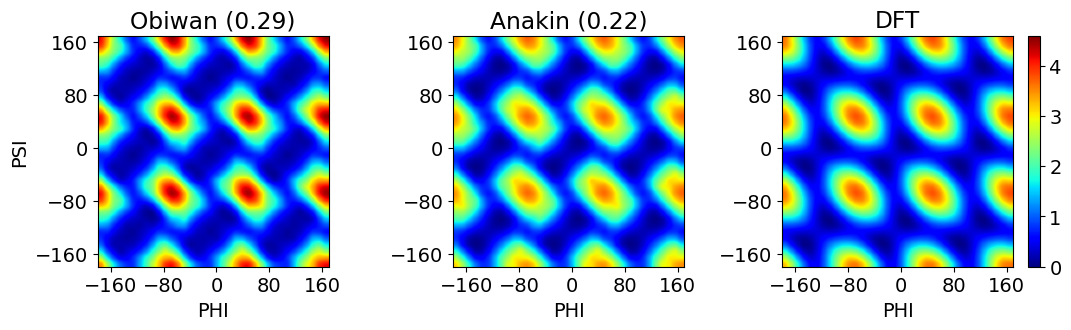

In [9]:
computeAndPlot("results/2D_torsion/xyzs_dftopt/hexafluoroacetone.xyz", obi_model, ani_model)

/var/folders/dg/j69tpxt95f334wmsgx38dgm40000gn/T/ipykernel_5813/1380585877.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


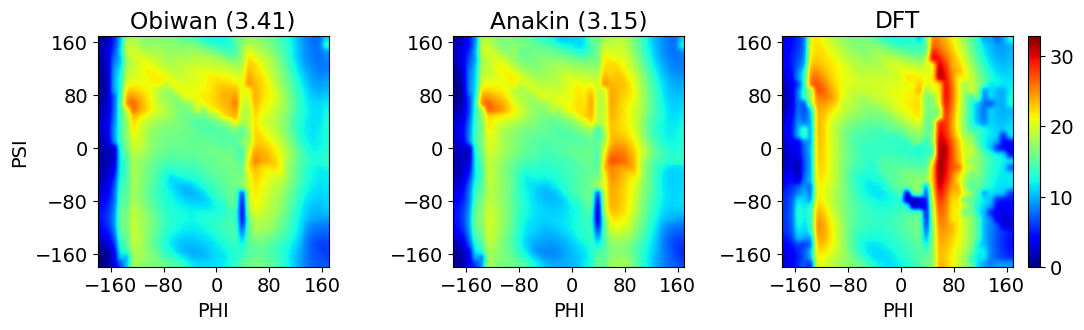

In [10]:
computeAndPlot("results/2D_torsion/xyzs_dftopt/cysteine_dipeptide.xyz", obi_model, ani_model)

/var/folders/dg/j69tpxt95f334wmsgx38dgm40000gn/T/ipykernel_5813/1380585877.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


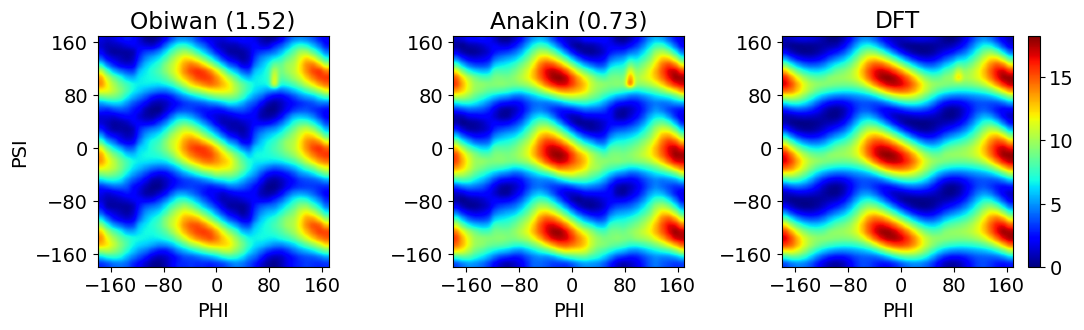

In [11]:
computeAndPlot("results/2D_torsion/xyzs_dftopt/DDT.xyz", obi_model, ani_model)

/var/folders/dg/j69tpxt95f334wmsgx38dgm40000gn/T/ipykernel_5813/1380585877.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


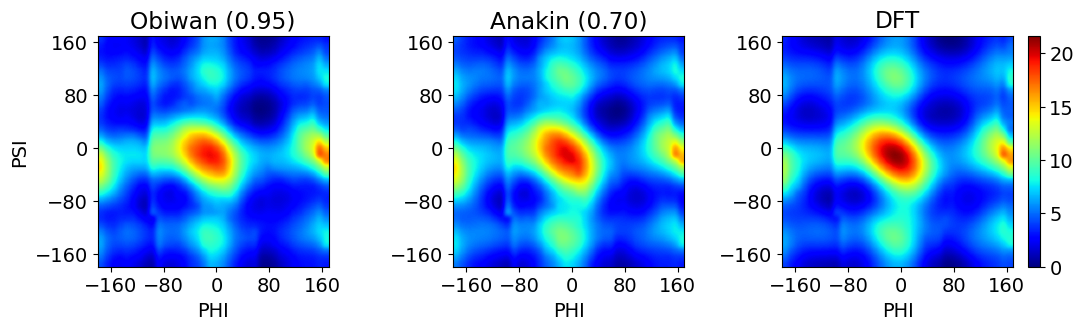

In [12]:
computeAndPlot("results/2D_torsion/xyzs_dftopt/bendamustine.xyz", obi_model, ani_model)